# <center>Computing the count rate of observing <a href="https://en.wikipedia.org/wiki/HAT-P-11">HAT-P-11</a> with the APO 3.5m telescope using <tt>synphot</tt></center>

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.modeling.blackbody import blackbody_lambda

import synphot.units as units
from synphot.models import BlackBody1D, BlackBodyNorm1D, Empirical1D
from synphot.spectrum import SourceSpectrum, SpectralElement
from synphot.observation import Observation

### Compute the photon flux (of HAT-P-11)

First we are going to download a model spectrum for HAT-P-11 from <a href="http://phoenix.astro.physik.uni-goettingen.de/">PHOENIX</a>:

In [ ]:
T_eff = 4800 # approx temperature of hatp11[K], Bakos et al. 2010

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=T_eff, log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

Then construct a `synphot` <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">source spectrum object</a> from the above arrays:

In [ ]:
photlam_hatp11 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Compute the flux at Earth from the luminosity 
R = 0.683 * u.R_sun  # radius in solar units, Deming et al. 2011
d = 123 * u.lyr # distance to HATP11 in light years from Gaia parallax
photlam_hatp11 = photlam_hatp11 * float(R / d) ** 2 / np.pi

photlam_hatp11.plot(flux_unit='Jy', left=0, right=60000)

(for other methods of constructing source spectra with `synphot`, see the first bulleted list <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">here</a>) 

### Simulate the observation with a specific instrument

<p>Let's observe HAT-P-11 with the <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/">ARCTIC instrument</a> on APO's 3.5m telescope.

In [ ]:
r = 3.5 / 2 * u.m  # radius of 3.5m ARC telescope at APO
area = np.pi * r ** 2
gain = 1.9  # the gain of this detector in e-/ADU

For the bandpass, we will use the SDSS filters - obtaining the transmission functions <a href="http://filters.apo.nmsu.edu/curves/SDSS/">here</a>. 
<p>To construct a bandpass from a file with <tt>synphot</tt>, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a>:</p>

In [ ]:
sdss = ['u', 'g', 'r', 'i', 'z']

bandpasses = {}
for band in sdss:
    bp = SpectralElement.from_file('sdss/' + band + '.dat')
    bandpasses[band] = bp
    
    plt.plot(bp.waveset, bp(bp.waveset), label=band)
plt.legend(loc='lower right')
plt.xlim(3000, 14000)
plt.show()

Then we model the attenuation by the atmosphere using the Cerro Paranal model transmittance curves for an airmass of 1.5:

In [ ]:
atmos = SpectralElement.from_file('CerroParanal-atmosx1.5.txt', wave_unit="nm")
atmos.plot(left=3000, right=14000)

We also model the affect of the CCD's quantum efficiency on the spectrum. For this we use the values in the table found in section 3.5 on <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/#3p5">this page</a>.

In [ ]:
qe = SpectralElement.from_file('ccd_QE.csv', wave_unit="nm")
qe._model.lookup_table /= 100  # convert percentages to decimals

qe.plot(left=3000, right=14000)

Once we have all of the effects on the source spectrum set, we can combine them together by simply multiplying the SpectralElement objects:

In [ ]:
bp_atmos_qe = {} # setting up a dictionary for the different SDSS bands
for band in sdss:
    bp_atmos_qe[band] = bandpasses[band] * atmos * qe
    
bp_atmos_qe['r'].plot(left=3000, right=14000)

Finally, we convolve the source spectrum with all of these effects using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html">Observation</a>:

In [ ]:
obs = {}
for band in sdss:
    obs[band] = Observation(photlam_hatp11, 
                      bp_atmos_qe[band],
                      binset=bp_atmos_qe[band].waveset,
                      force='taper')

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate">countrate()</a> method: 

In [ ]:
waverange = (3000, 11000) # according to the ARCTIC webpage, the z band is cut off at 11k AA

print("HAT-P-11 counts in each filter for 10 s exposure:")
for band in sdss:
    # enforce the wavelength range by setting waverange
    countrate = obs[band].countrate(area=area, waverange=waverange) / gain
    print(band + ":", countrate * 10 * u.s)

# <center>Same instrument and telescope, this time observing <a href="https://en.wikipedia.org/wiki/TRAPPIST-1">TRAPPIST-1</a></center>

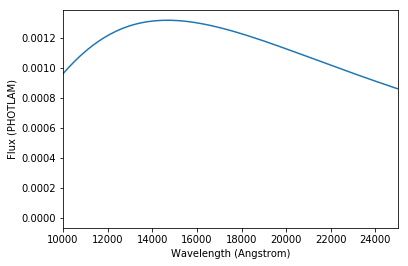

In [18]:
T_eff = 2500  # temperature of trappist-1 [K], Delrez et al. 2018

photlam_trappist1 = SourceSpectrum(BlackBody1D, temperature=T_eff)

# Compute the flux at Earth from the luminosity 
R = 0.121 * u.R_sun  # radius of trappist-1 in solar units, Van Grootel et al. 2018
d = 39.6 * u.lyr  # distance to trappist-1 in light years from Gaia parallax
photlam_trappist1 = photlam_trappist1 * float(R / d) ** 2

photlam_trappist1.plot(left=10000, right=25000)

(including the effects of the QE and atmosphere)

In [19]:
print("TRAPPIST-1 counts in each filter for 10s exposure:")
for band in sdss:
    bp = SpectralElement.from_file('sdss/' + band + '.dat')
    obs = Observation(photlam_trappist1, bp * qe * atmos, binset=bp.waveset)
    
    countrate = obs.countrate(area=area, waverange=waverange) / gain
    print(band + ":", countrate * 10 * u.s)

TRAPPIST-1 counts in each filter for 10s exposure:
u: 183.54453225836775 ct
g: 19952.369757809432 ct
r: 116953.76544968956 ct
i: 294517.67909918143 ct
z: 261556.97303697298 ct
